# LDC Implementation in Python/JAX
Written By: Sungje Park

In [1]:
import jax
from jax import numpy as jnp

import sys
sys.path.append('..')
from src.dynamics import *
from src.environment import *
from src.containers import *
from utils.test_utils import *
from tqdm import tqdm
import matplotlib.pyplot as plt

Defining Vars.

In [2]:
rho_ref = 1 # reference density
Mu = .1 # kinematic Viscosity
Re = 100 # reynolds number
N_x = 250 # number of cells in the x dir
N_y = N_x # number of cells in the y dir
dx = 1 # spacing in x
dy = 1 # spacing in y
U_lid = Re*Mu/N_x # velocity of lid
Tau = 3*Mu+.5
dt = .1

In [3]:
cell_mesh = jnp.reshape(jnp.asarray(range(N_x*N_y)),(N_y,N_x))
node_mesh = jnp.reshape(jnp.asarray(range((N_x+1)*(N_y+1))),(N_y+1,N_x+1))
face_mesh = jnp.asarray(range(N_x*(N_y+1)+(N_x+1)*N_y))
vert_mesh = jnp.reshape(face_mesh[0:N_x*(N_y+1)],(N_y,N_x+1))
horz_mesh = jnp.reshape(face_mesh[N_x*(N_y+1):],(N_y+1,N_x))

In [4]:
dynamics = D2Q9(tau=Tau,delta_t = dt)
Environment.dynamics = dynamics

In [5]:
env = Environment.create(N_x*N_y,(N_x)*(N_x+1)*2,(N_x+1)*(N_y+1))

In [6]:
def setup_cell(cell_ind):
    loc = jnp.argwhere(cell_mesh == cell_ind)[0]
    x = loc[1]
    y = loc[0]
    face_ind = jnp.asarray([vert_mesh[y,x],
                            horz_mesh[y,x],
                            vert_mesh[y,x+1],
                            horz_mesh[y+1,x]])
    face_n = jnp.asarray([0,0,1,1])
    env.cells.face_indices.add_items(cell_ind,face_ind)
    env.cells.face_normals.add_items(cell_ind,face_n)

cells = [setup_cell(ind) for ind in tqdm(range(N_x*N_y))]
# Correction to flip face normals
env.cells.face_normals.data = jnp.where(env.cells.face_normals.data==0,-1,env.cells.face_normals.data)

100%|██████████| 62500/62500 [06:48<00:00, 153.01it/s]


In [7]:
def setup_node(node_ind):
    loc = jnp.argwhere(node_mesh==node_ind)[0]
    x = loc[1]
    y = loc[0]
    cell_index = []
    cell_dists = []
    cell_dist = jnp.sqrt(2)
    def cell_append(tl,tr,bl,br):
        if tl:
            cell_index.append(cell_mesh[y-1,x-1]) # top left
            cell_dists.append(cell_dist)
        if tr:
            cell_index.append(cell_mesh[y-1,x]) # top right
            cell_dists.append(cell_dist)

        if br:
            cell_index.append(cell_mesh[y,x]) # bottom right
            cell_dists.append(cell_dist)

        if bl:
            cell_index.append(cell_mesh[y,x-1])# bottom left
            cell_dists.append(cell_dist)

    if y == 0:
        type = 1
        vel = jnp.asarray([U_lid,0])
        if x!=0 and x!=N_x:
            cell_append(False,False,True,True)
        elif x==0:
            vel = jnp.asarray([0,0])
            cell_append(False,False,False,True)
        elif x==N_x:
            vel = jnp.asarray([0,0])
            cell_append(False,False,True,False)

    elif y == N_y:
        type = 1
        vel = jnp.asarray([0,0])
        if x!=0 and x!=N_x:
            cell_append(True,True,False,False)
        elif x==0:
            cell_append(False,True,False,False)
        elif x==N_x:
            cell_append(True,False,False,False)

    elif x == 0:
        type = 1
        vel = jnp.asarray([0,0])
        # since all corner cases handled
        
        cell_append(False,True,False,True)

    elif x == N_x:
        type = 1
        vel = jnp.asarray([0,0])
        cell_append(True,False,True,False)
    else:
        type = 0
        cell_append(True,True,True,True)

    env.nodes.type = env.nodes.type.at[node_ind].set(jnp.asarray(type))
    env.nodes.cells_index.add_items(node_ind,jnp.asarray(cell_index))
    env.nodes.cell_dists.add_items(node_ind,jnp.asarray(cell_dists))
    if type == 1:
        env.nodes.vel = env.nodes.vel.at[node_ind].set(vel)
nodes = [setup_node(ind) for ind in tqdm(range((N_x+1)*(N_y+1)))]

100%|██████████| 63001/63001 [07:07<00:00, 147.37it/s]


In [8]:
def setup_face(face_ind):
    nodes_ind = []
    stencil_ind = []
    stencil_dists = jnp.asarray([.5,.5])
    
    if face_ind < N_x*(N_y+1): # vertical faces
        loc = jnp.argwhere(vert_mesh==face_ind)[0]
        x = loc[1]
        y = loc[0]
        nodes_ind.append(jnp.asarray(node_mesh[y,x]))
        nodes_ind.append(jnp.asarray(node_mesh[y+1,x]))

        if x == 0:
            stencil_ind.append(-2)
            stencil_ind.append(cell_mesh[y,x])
        elif x == N_x:
            stencil_ind.append(cell_mesh[y,x-1])
            stencil_ind.append(-2)
        else:
            stencil_ind.append(cell_mesh[y,x-1])
            stencil_ind.append(cell_mesh[y,x])

        n = jnp.asarray([1,0])
    else: # horizontal faces
        loc = jnp.argwhere(horz_mesh==face_ind)[0]
        x = loc[1]
        y = loc[0]
        nodes_ind.append(jnp.asarray(node_mesh[y,x]))
        nodes_ind.append(jnp.asarray(node_mesh[y,x+1]))

        if y == 0:
            stencil_ind.append(-2)
            stencil_ind.append(cell_mesh[y,x])
        elif y == N_y:
            stencil_ind.append(cell_mesh[y-1,x])
            stencil_ind.append(-2)
        else:
            stencil_ind.append(cell_mesh[y-1,x])
            stencil_ind.append(cell_mesh[y,x])

        n = jnp.asarray([0,1])

    #face = Face.pdf_init(pdf,jnp.asarray(nodes_ind),jnp.asarray(stencil_ind),jnp.asarray(stencil_dists),n,jnp.asarray(1))
    env.faces.nodes_index.add_items(face_ind, jnp.asarray(nodes_ind))
    env.faces.stencil_cells_index.add_items(face_ind, jnp.asarray(stencil_ind))
    env.faces.stencil_dists.add_items(face_ind, jnp.asarray(stencil_dists))
    env.faces.n = env.faces.n.at[face_ind].set(n)
    env.faces.L = env.faces.L.at[face_ind].set(jnp.asarray(1))

faces = [setup_face(ind) for ind in tqdm(range((N_x)*(N_x+1)*2))]
env.faces.stencil_cells_index.data = jnp.where(env.faces.stencil_cells_index.data==-2,-1,env.faces.stencil_cells_index.data)

100%|██████████| 125500/125500 [13:04<00:00, 160.04it/s] 


In [9]:
env.init()

In [10]:
env = env.step()

In [51]:
for i in tqdm(range(100000)):
    env = env.step()

  4%|▍         | 4299/100000 [00:25<09:21, 170.42it/s]


KeyboardInterrupt: 

In [52]:
vel = env.cells.vel/U_lid

In [53]:
x = jnp.linspace(1/2/N_x,1-1/2/N_x,N_x)
y = jnp.linspace(1/2/N_y,1-1/2/N_y,N_y)
# x,y = jnp.meshgrid(x,y)
# x = x.flatten()
# y = y.flatten()

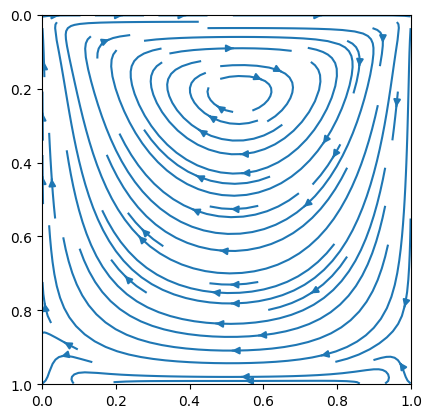

In [54]:
import numpy as np
x = np.linspace(1/(2*N_x),1-1/(2*N_x),N_x)
y = np.linspace(1/(2*N_y),1-1/(2*N_y),N_y)
u = np.asarray(vel[...,0].reshape(N_x,N_y))
v = np.asarray(vel[...,1].reshape(N_x,N_y))
plt.streamplot(x,y,u,v)
plt.axis("square")
plt.xlim([0,1])
plt.ylim([0,1])
plt.gca().invert_yaxis()
plt.show()

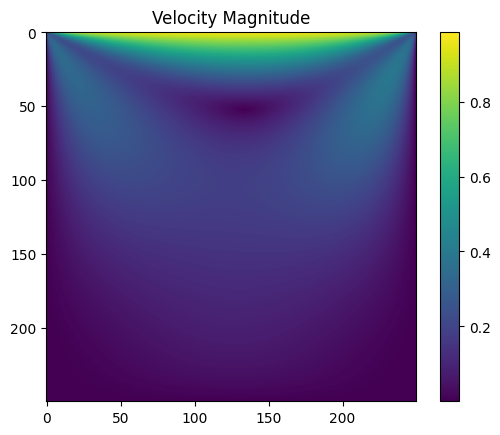

In [55]:
plt.imshow(jnp.sqrt(vel[...,0]**2+vel[...,1]**2).reshape(N_x,N_y))
plt.title("Velocity Magnitude")
plt.colorbar()
plt.show()

In [56]:
outx = jnp.mean(vel.reshape(N_x,N_y,2)[124:126,:,1],axis=0)
outy = jnp.mean(vel.reshape(N_x,N_y,2)[:,124:126,0],axis=1)

In [57]:
from scipy.io import loadmat
data = loadmat('../ref/ldc_Re100.mat')
refu = data['u'].T[...,jnp.newaxis]
refv = data['v'].T[...,jnp.newaxis]
refx = data['x'].squeeze()
refy = data['y'].squeeze()
# x,y = jnp.meshgrid(x,y)
# x = jnp.expand_dims(x.flatten(),axis=-1)
# y = jnp.expand_dims(y.flatten(),axis=-1)
# xy = jnp.concatenate((x,y),axis=-1)
sol = jnp.concatenate((refu,refv),axis=-1)

In [58]:
solx = sol[128,:,1]
soly = sol[:,128,0]

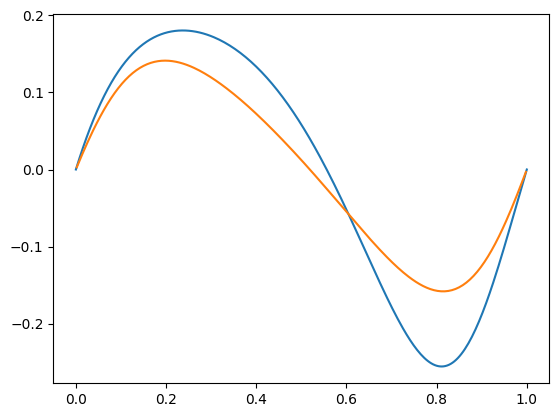

In [59]:
plt.plot(refy,solx)
plt.plot(x,-outx)
plt.xlabel
plt.show()

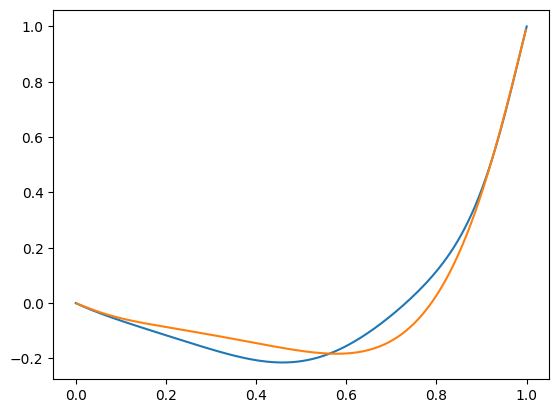

In [60]:
plt.plot(refy,soly)
plt.plot(np.flip(y),outy)
plt.xlabel
plt.show()